In [ ]:
#Load Dataset
def loadDataset():  
  df = pd.read_csv('vanityPlates.csv')

  return df

In [ ]:
# Split DataFrame into Data and Target
def getDataTargetSets(df):
  temp = df
  status_list = df['status']
  target_df = pd.DataFrame(status_list, columns = ['status']) 
  #target_df = df['status']
  temp.drop(['status'], axis=1 , inplace=True)
  #dfs = np.split(df, [4], axis=1)

  return temp, target_df

In [ ]:
# Check profanity probability of each vanity plate
def runProfanityCheck(df):
  plateArr = df['plate']
  plate_prof_probs = []
  for plate in plateArr:
    plate_prof_probs.append(predict_prob([plate])[0])
  return plate_prof_probs

In [ ]:
# Load bad_words text file
def getOffensiveWords():
  with open('offensive_words.txt') as f:
      offensive_word_list = [word.upper() for line in f for word in line.split()]
  f.close()
  #offensive_words = ' '.join(word[0] for word in offensive_word_list)
  #print(offensive_word_list)
  return offensive_word_list

In [ ]:
# String match with offensive words
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

def get_offensive_plate_ratio(df):
  offensive_word_list = getOffensiveWords()
  plateArr = df['plate']
  plate_offensive_ratios = []
  
  for plate in plateArr:
    off_ratio = 0
    offensive_ratios = []
    for off_word in offensive_word_list:
      off_ratio = fuzz.ratio(plate, off_word)
      offensive_ratios.append(off_ratio)
      if off_ratio == 100:
        break
    plate_offensive_ratios.append(max(offensive_ratios))

  return plate_offensive_ratios

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
# Perform one hot encoding for vanity plate text
def one_hot_encode_plate(df):
  alphaNumChars="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789@#$%^&* "
  plate_texts = df['plate'].values
  for char in alphaNumChars:
    newPlateColName = "plate_"+char
    plateChars = []
    for plate in plate_texts:
      if char in plate:
        plateChars.append('1')
      else:
        plateChars.append('0')
    df[newPlateColName] = plateChars

  return df

In [ ]:
# Perform one hot encoding for review reason code
def one_hot_encode_review_reason_code(df):

  df = pd.concat([df, pd.get_dummies(df['review_reason_code'], prefix='review_reason_code')], axis=1)
  df.drop(['review_reason_code'], axis=1, inplace=True)
  
  return df

In [ ]:
def train_test_split(X, y):
  from sklearn.model_selection import train_test_split

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
  print("No. of samples in X_train: ", len(X_train))
  print("No. of samples in X_test: ", len(X_test))
  print("No. of samples in y_train: ", len(y_train))
  print("No. of samples in y_test: ", len(y_test))

  return X_train, X_test, y_train, y_test

In [ ]:
!pip install profanity-check
import pandas as pd
import numpy as np
from profanity_check import predict, predict_prob

# Load the dataset
df = loadDataset()

# Get Profanity Probability
plate_prof_probs = runProfanityCheck(df)
df['plate_profanity'] = plate_prof_probs

# Get plate text offensive ratio

#plate_offensive_ratios = get_offensive_plate_ratio(df)
with open('offensivePlateRatios.txt') as f:
  plate_offensive_ratios = [word.upper() for line in f for word in line.split()]
f.close()

print(plate_offensive_ratios)
df['plate_offensive_ratio'] = plate_offensive_ratios

# One-Hot Encode Vanity Plates - Character level
df = one_hot_encode_plate(df)

# One-Hot Encode Review Reason Code
df = one_hot_encode_review_reason_code(df)

#cleanup: drop string columns so that PCA will work 
df.drop(['plate', 'customer_meaning', 'reviewer_comments'], axis=1, inplace=True)
print(df.shape)

# Making new data frame with dropped NA values
new_df = df.dropna(axis = 0, how ='any')
  
# comparing sizes of data frames 
print("Old data frame length:", len(df), "\nNew data frame length:",  
       len(new_df), "\nNumber of rows with at least 1 NA value: ", 
       (len(df)-len(new_df))) 

#Split dataset into data and target
data_df, target_df = getDataTargetSets(new_df)

data_df.shape

     |████████████████████████████████| 2.4MB 2.9MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.svm.classes module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.svm. Anything that cannot be imp

['55', '60', '91', '62', '50', '62', '62', '55', '55', '55', '62', '57', '53', '25', '71', '62', '67', '62', '55', '67', '57', '57', '55', '46', '67', '50', '55', '62', '67', '67', '50', '67', '60', '36', '57', '50', '53', '60', '67', '55', '55', '62', '62', '73', '73', '57', '57', '55', '57', '40', '47', '53', '47', '62', '55', '71', '62', '57', '50', '62', '60', '55', '55', '67', '55', '40', '60', '62', '62', '50', '67', '50', '36', '46', '55', '55', '50', '80', '55', '50', '57', '60', '46', '62', '50', '71', '36', '62', '62', '46', '53', '73', '55', '40', '71', '46', '55', '60', '57', '62', '57', '71', '57', '46', '67', '50', '50', '62', '53', '55', '57', '60', '57', '57', '62', '53', '55', '60', '82', '71', '62', '67', '67', '67', '62', '36', '67', '60', '55', '46', '63', '67', '55', '67', '57', '62', '55', '67', '50', '57', '50', '50', '40', '67', '55', '57', '46', '57', '62', '62', '67', '67', '53', '73', '62', '57', '46', '71', '62', '57', '50', '50', '62', '50', '55', '38', '55

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(23430, 122)

In [ ]:
# Status count in dataset
print(target_df['status'].value_counts())

N    18757
Y     4673
Name: status, dtype: int64


In [ ]:
# Split Dataset into train and test
X = data_df.to_numpy()
y = target_df.to_numpy()

print(X)
print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y)

[[0.12095604436347504 '55' '1' ... 0 0 0]
 [0.12095604436347504 '60' '1' ... 0 0 0]
 [0.12095604436347504 '91' '0' ... 0 0 0]
 ...
 [0.12095604436347504 '50' '0' ... 0 0 0]
 [0.12095604436347504 '93' '1' ... 0 0 0]
 [0.12095604436347504 '60' '0' ... 0 0 0]]
[['N']
 ['N']
 ['N']
 ...
 ['N']
 ['N']
 ['Y']]
No. of samples in X_train:  18744
No. of samples in X_test:  4686
No. of samples in y_train:  18744
No. of samples in y_test:  4686


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Text(0, 0.5, 'recall')

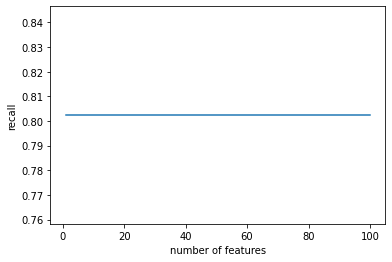

In [ ]:
#determine number of features with PCA evaluating on simple SVM model with stratified cross validation

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline

numfeatures = []
recall_pca = []
for features in [100, 80, 60, 40, 35, 30, 25, 20, 15, 10, 5, 1]: 
  #dimensionality reduction
  pca = PCA(n_components=features)
  pca.fit(X_train)
  X_train_reduced = pca.transform(X_train)
  #svm
  svm_pca = SVC()
  svm_pca_recalls = cross_val_score(svm_pca, X_train_reduced, y_train, cv=5, scoring='recall_micro')
  svm_pca_recalls_avg = svm_pca_recalls.mean()
  #NB
  #NB_pca = GaussianNB()
  #NB_pca_recalls = cross_val_score(NB_pca, X_train_reduced, y_train, cv=5, scoring='recall_micro')
  #NB_pca_recalls_avg = NB_pca_recalls.mean()
  #Decision tree
  #DT_pca = DecisionTreeClassifier()
  #DT_pca_recalls = cross_val_score(DT_pca, X_train_reduced, y_train, cv=5, scoring='recall_weighted')
  #DT_pca_recalls_avg = DT_pca_recalls.mean()
  numfeatures.append(features)
  recall_pca.append(svm_pca_recalls_avg)
  #np.ravel(y_train,order='C')

plt.plot(numfeatures, recall_pca)
plt.xlabel("number of features")
plt.ylabel("recall")

In [ ]:
# Perform 5-Fold Stratified cross-validation

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

skFold = StratifiedKFold(n_splits = 5)

#Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier

best_score_dt = 0
criterion_settings = ["gini", "entropy"]
depth_settings = range(5, 30)

for criterion_value in criterion_settings:
  for depth_value in depth_settings:
    # Build model
    dTreeClassifier = DecisionTreeClassifier(criterion=criterion_value, max_depth=depth_value)

    fold_recall_dt = cross_val_score(dTreeClassifier, X_train, y_train, scoring='recall_macro', cv=skFold)
    #print("Cross_validation_score: \n{}".format(fold_recall_dt.mean()))
    score = fold_recall_dt.mean()
    if score > best_score_dt:
      best_param_dt = {'criterion': criterion_value, 'max_depth': depth_value}
      best_score_dt = score

print(best_param_dt)
print(best_score_dt)
# print(data_df.shape)
# print(target_df.shape)
# print(target_df['status'].value_counts())

{'criterion': 'entropy', 'max_depth': 27}
0.573870495932016


In [ ]:
# Tune hyperparameters for SVM using stratified 5-fold cross-validation
from sklearn.svm import SVC

best_score_svm = 0
degree_settings = range(2,5)
gamma_settings = ["auto", "scale"]
c_settings = [1e-6, 0.00001, 0.0001, 0.001]

for degree_value in degree_settings:
  for gamma_value in gamma_settings:
    for c_value in c_settings:
    # Build model
      svmClassifier = SVC(kernel="poly", degree=degree_value, gamma=gamma_value, C=c_value)

      fold_recall_svm = cross_val_score(svmClassifier, X_train, np.ravel(y_train,order='C'), scoring='recall_macro', cv=skFold)
      #print("Cross_validation_score: \n{}".format(fold_recall_svm.mean()))
      score = fold_recall_svm.mean()
      if score > best_score_svm:
        best_param_svm = {'degree': degree_value, 'gamma': gamma_value, 'C': c_value, 'kernel':'poly'}
        best_score_svm = score

print(best_score_svm)
print(best_param_svm)


In [ ]:
# Train Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB

gaussian_model = GaussianNB()
fold_recall_nb = cross_val_score(gaussian_model, X_train, np.ravel(y_train,order='C'), scoring='recall_macro', cv=skFold)
score_nb = fold_recall_nb.mean()
print(score_nb)

0.5028328328867243


In [ ]:
# Retrain KNN
kClassifier = KNeighborsClassifier(**best_param_knn)
kClassifier.fit(X_train, y_train)

#Retrain DecisionTree
dTreeClassifier = DecisionTreeClassifier(**best_param_dt)
dTreeClassifier.fit(X_train, y_train)

#Retrain SVM
svmClassifier = SVC(**best_param_svm)
svmClassifier.fit(X_train, y_train)


In [ ]:
# Experiment 3 - Ensemble Learning
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

# Majority Vote Classifier
enClf = VotingClassifier(estimators=[('dt', dTreeClassifier),('svm', svmClassifier),('gnb', gaussian_model)], voting='hard')
fold_precision_mvote = cross_val_score(enClf, X_train, y_train, cv=skFold, scoring='precision_macro')
fold_recall_mvote = cross_val_score(enClf, X_train, y_train, cv=skFold, scoring='recall_macro')
print("Majority Vote Classifier")
print(fold_precision_mvote)
print(fold_recall_mvote)
print(fold_precision_mvote.mean())
print(fold_recall_mvote.mean())

# Bagging classifier for DecisionTree
baggingClf_dt = BaggingClassifier(dTreeClassifier)

fold_precision_bag_dt = cross_val_score(baggingClf_dt, X_train, y_train, cv=skFold, scoring='precision_macro')
fold_recall_bag_dt = cross_val_score(baggingClf_dt, X_train, y_train, cv=skFold, scoring='recall_macro')
print("Bagging Classifier - Decision Tree")
print(fold_precision_bag_dt)
print(fold_recall_bag_dt)
print(fold_precision_bag_dt.mean())
print(fold_recall_bag_dt.mean())

# Bagging classifier for SVM
baggingClf_svm = BaggingClassifier(svmClassifier)
fold_precision_bag_svm = cross_val_score(baggingClf_svm, X_train, y_train, cv=skFold, scoring='precision_macro')
fold_recall_bag_svm = cross_val_score(baggingClf_svm, X_train, y_train, cv=skFold, scoring='recall_macro')
print("Bagging Classifier - SVM")
print(fold_precision_bag_svm)
print(fold_recall_bag_svm)
print(fold_precision_bag_svm.mean())
print(fold_recall_bag_svm.mean())

# Bagging classifier for NaiveBayesGaussian
baggingClf_gnb = BaggingClassifier(gaussian_model)
fold_precision_bag_gnb = cross_val_score(baggingClf_gnb, X_train, y_train, cv=skFold, scoring='precision_macro')
fold_recall_bag_gnb = cross_val_score(baggingClf_gnb, X_train, y_train, cv=skFold, scoring='recall_macro')
print("Bagging Classifier - NaiveBayes")
print(fold_precision_bag_gnb)
print(fold_recall_bag_gnb)
print(fold_precision_bag_gnb.mean())
print(fold_recall_bag_gnb.mean())


# AdaBoost classifier for DecisionTree
adabooster_dt = AdaBoostClassifier(base_estimator=dTreeClassifier, n_estimators = 50)
fold_precision_boost_dt = cross_val_score(adabooster_dt, X_train, y_train, cv=skFold, scoring='precision_macro')
fold_recall_boost_dt = cross_val_score(adabooster_dt, X_train, y_train, cv=skFold, scoring='recall_macro')
print("Boosting Classifier - DecisionTree")
print(fold_precision_boost_dt)
print(fold_recall_boost_dt)
print(fold_precision_boost_dt.mean())
print(fold_recall_boost_dt.mean())

# AdaBoost classifier for SVM
adabooster_svm = AdaBoostClassifier(base_estimator=svmClassifier, n_estimators = 50)
fold_precision_boost_svm = cross_val_score(adabooster_svm, X_train, y_train, cv=kfold, scoring='precision_macro')
fold_recall_boost_svm = cross_val_score(adabooster_svm, X_train, y_train, cv=kfold, scoring='recall_macro')
print("Boosting Classifier - SVM")
print(fold_precision_boost_svm)
print(fold_recall_boost_svm)	

# AdaBoost classifier for NaiveBayes
adabooster_gnb = AdaBoostClassifier(base_estimator=gaussian_model, n_estimators = 50)
fold_precision_boost_gnb = cross_val_score(adabooster_gnb, X_train, y_train, cv=kfold, scoring='precision_macro')
fold_recall_boost_gnb = cross_val_score(adabooster_gnb, X_train, y_train, cv=kfold, scoring='recall_macro')
print("Boosting Classifier - NaiveBayes")
print(fold_precision_boost_gnb)
print(fold_recall_boost_gnb)
print(fold_precision_boost_gnb.mean())
print(fold_recall_boost_gnb.mean())

In [ ]:
# experiment 4: train/determine hyperparameters for MLPClassifier 
from sklearn.neural_network import MLPClassifier

#optimize hidden layers and # of neurons
recall_1hl = []
recall_2hl = []
recall_3hl = []
n_neurons_per_l = []
for n_hidden_units in [10, 25, 50, 100]:
  n_neurons_per_l.append(n_hidden_units)
  #one hidden layer
  mlp1 = MLPClassifier(hidden_layer_sizes= [n_hidden_units], max_iter=50)
  mlp1_recalls = cross_val_score(mlp1, X_train, y_train, cv=5, scoring='recall_macro')
  mlp1_recalls_avg = mlp1_recalls.mean()
  recall_1hl.append(mlp1_recalls_avg)
  #two hidden layers
  mlp2 = MLPClassifier(hidden_layer_sizes= [n_hidden_units, n_hidden_units], max_iter=50)
  mlp2_recalls = cross_val_score(mlp2, X_train, y_train, cv=5, scoring='recall_macro')
  mlp2_recalls_avg = mlp2_recalls.mean()
  recall_2hl.append(mlp2_recalls_avg)
  #three hidden layers
  mlp3 = MLPClassifier(hidden_layer_sizes= [n_hidden_units, n_hidden_units, n_hidden_units], max_iter=50)
  mlp3_recalls = cross_val_score(mlp3, X_train, y_train, cv=5, scoring='recall_macro')
  mlp3_recalls_avg = mlp3_recalls.mean()
  recall_3hl.append(mlp3_recalls_avg)


#plot
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(n_neurons_per_l, recall_1hl, label="1 hidden layer")
plt.plot(n_neurons_per_l, recall_2hl, label="2 hidden layers")
plt.plot(n_neurons_per_l, recall_3hl, label="3 hidden layers")
plt.xlabel("Neurons per layer")
plt.ylabel("Recall")
plt.legend()

NameError: ignored

In [ ]:
'hidden_layer_sizes': [x for x in itertools.product((10,20,30,40,50,100),repeat=3)]


parameters={
'learning_rate': ["constant", "invscaling", "adaptive"],
'hidden_layer_sizes': [(100,1), (100,2), (100,3)],
'alpha': [10.0 ** -np.arange(1, 7)],
'activation': ["logistic", "relu", "Tanh"]
}

clf
= gridSearchCV(estimator=MLPClassifier,param_grid=parameters,n_jobs=-1,verbose=2,cv=10)
# experiment 4: train/determine hyperparameters for MLPClassifier 
from sklearn.neural_network import MLPClassifier

#optimize hidden layers and # of neurons
recall_1hl = []
recall_2hl = []
recall_3hl = []
n_neurons_per_l = []
for n_hidden_units in [10, 25, 50, 100]:
  n_neurons_per_l.append(n_hidden_units)
  #one hidden layer
  mlp1 = MLPClassifier(hidden_layer_sizes= [n_hidden_units], max_iter=50)
  mlp1_recalls = cross_val_score(mlp1, X_train, y_train, cv=5, scoring='recall_macro')
  mlp1_recalls_avg = mlp1_recalls.mean()
  recall_1hl.append(mlp1_recalls_avg)
  #two hidden layers
  mlp2 = MLPClassifier(hidden_layer_sizes= [n_hidden_units, n_hidden_units], max_iter=50)
  mlp2_recalls = cross_val_score(mlp2, X_train, y_train, cv=5, scoring='recall_macro')
  mlp2_recalls_avg = mlp2_recalls.mean()
  recall_2hl.append(mlp2_recalls_avg)
  #three hidden layers
  mlp3 = MLPClassifier(hidden_layer_sizes= [n_hidden_units, n_hidden_units, n_hidden_units], max_iter=50)
  mlp3_recalls = cross_val_score(mlp3, X_train, y_train, cv=5, scoring='recall_macro')
  mlp3_recalls_avg = mlp3_recalls.mean()
  recall_3hl.append(mlp3_recalls_avg)


#plot
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(n_neurons_per_l, recall_1hl, label="1 hidden layer")
plt.plot(n_neurons_per_l, recall_2hl, label="2 hidden layers")
plt.plot(n_neurons_per_l, recall_3hl, label="3 hidden layers")
plt.xlabel("Neurons per layer")
plt.ylabel("Recall")
plt.legend()